# Task

### Pre-defined code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading all the images in the drive
gt_images = []

for files in tqdm(natsorted(glob('/content/drive/My Drive/ES666CV/images/B/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images) # Only possible because all images are of same size

100%|██████████| 6/6 [00:00<00:00, 135.93it/s]


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

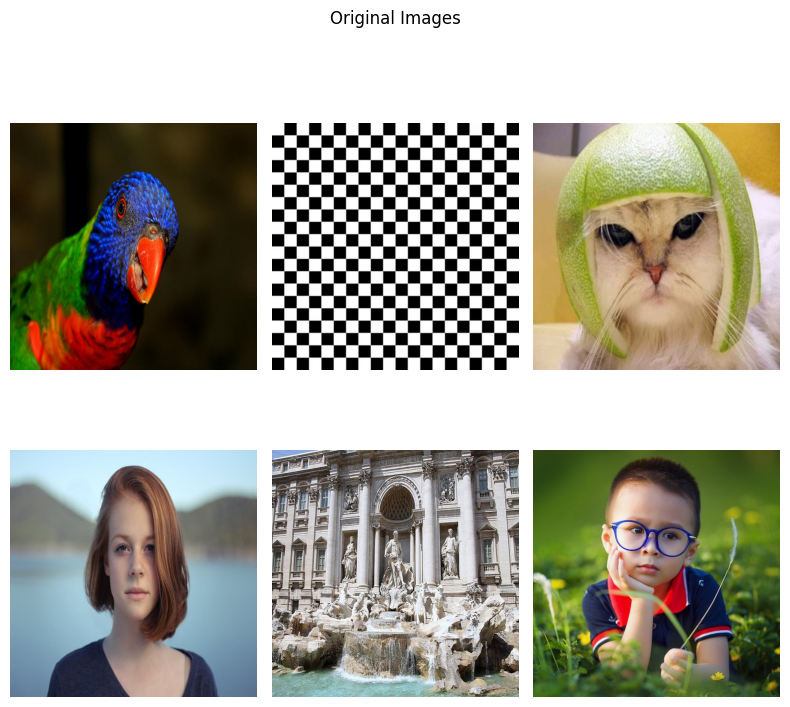

In [ ]:
show_image_grid(gt_images, 2, 3, 'Original Images', figsize=8)

### Q1 [2 Marks]

Implement Gaussian Pyramid Downsampling method from scratch.Compare it with Opencv resize method. What difference do you observe when you resize an image with Gaussian Pyramid approach and Opencv approach.

References:
1. [Gaussian & Laplacian pyramid	construction](https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf)
2. [Multi-Scale Representation](https://medium.com/jun94-devpblog/cv-4-multi-scale-representation-gaussian-and-laplacian-pyramid-527ca4c4831c)

In [ ]:
def pad_image_to_divisible(image, K, pad_value=0):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the padding needed for height and width
    pad_h = (K - (h % K)) % K  # Padding needed for height
    pad_w = (K - (w % K)) % K  # Padding needed for width

    # Compute the padding to add to top/bottom and left/right
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Pad the image: (top, bottom), (left, right), and (no padding on channels)
    if len(image.shape) == 3:  # For RGB images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                              mode='constant', constant_values=pad_value)
    else:  # For grayscale images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant', constant_values=pad_value)

    return padded_image

In [ ]:
def gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(1, levels):
        blurred = cv2.GaussianBlur(image, (5,5), sigmaX=1)  # Applying Gaussian blur
        downsampled = cv2.resize(blurred, (image.shape[1]//2, image.shape[0]//2))  # Downsampling by reducing the size by half

        downsampled = pad_image_to_divisible(downsampled, pyramid[0].shape[0])
        pyramid.append(downsampled)
        image = downsampled  # Updating for the next level

    return np.array(pyramid)

def opencv_resize(inp_image, levels):
    pyramid = []
    h, w    = inp_image.shape[:2]
    for i in range(levels):
        image = cv2.resize(inp_image, (h//2**i, w//2**i))

        image = pad_image_to_divisible(image, min(h, w))
        pyramid.append(image)

    return np.array(pyramid)

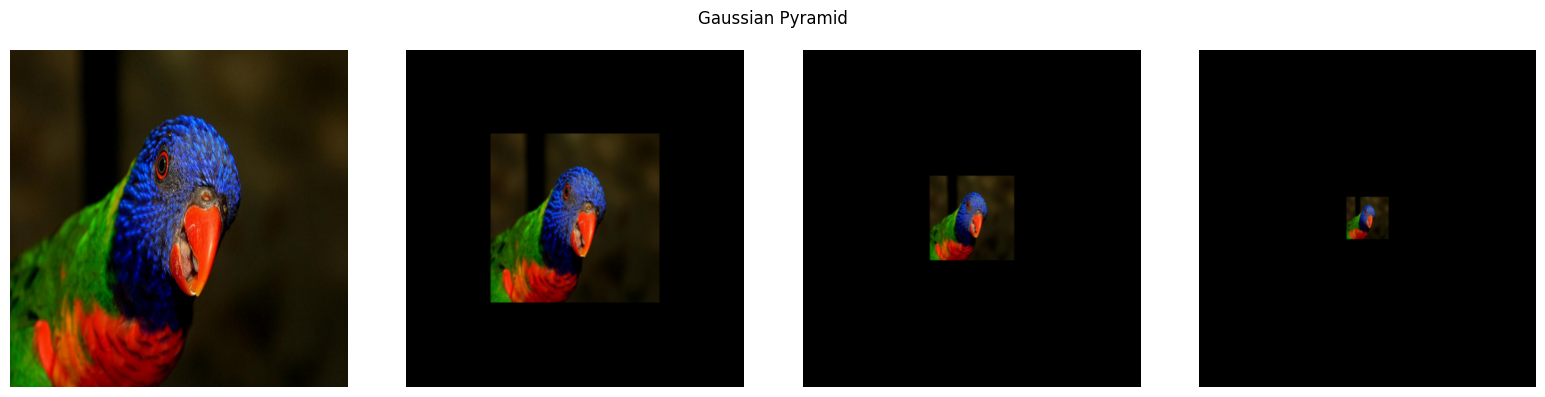

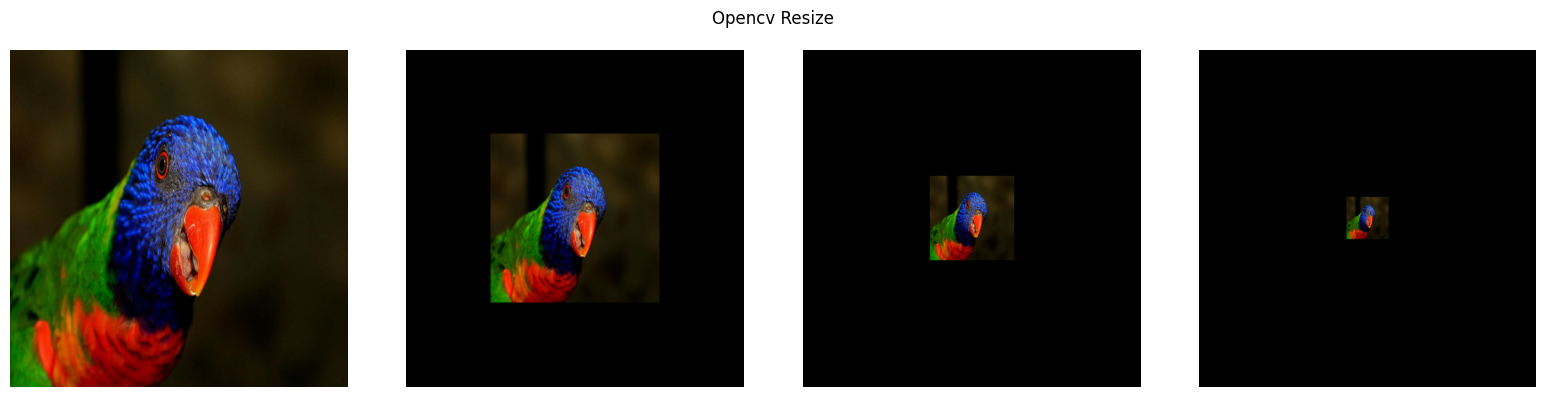

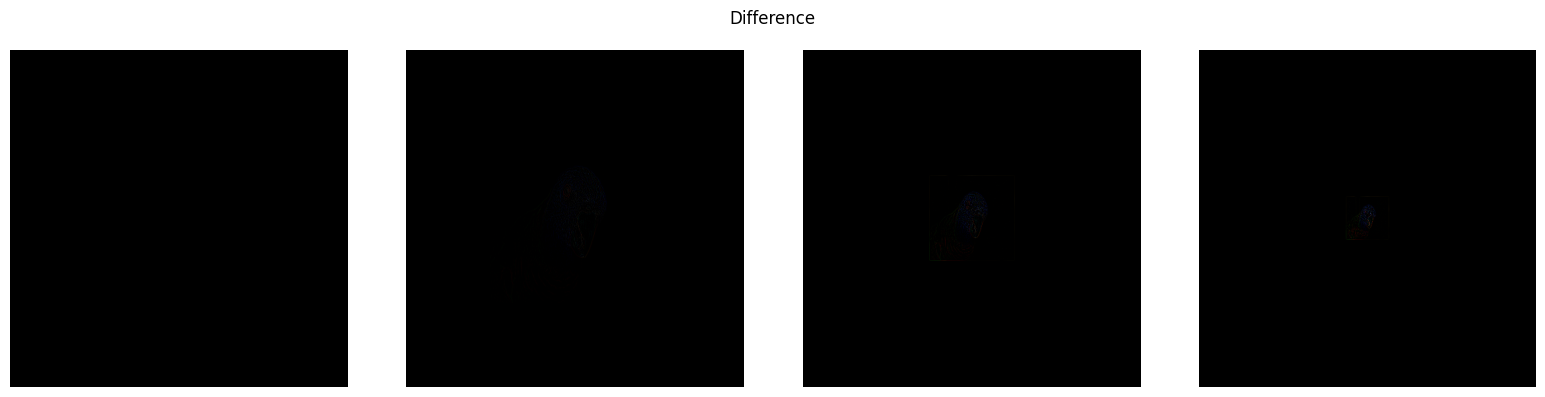

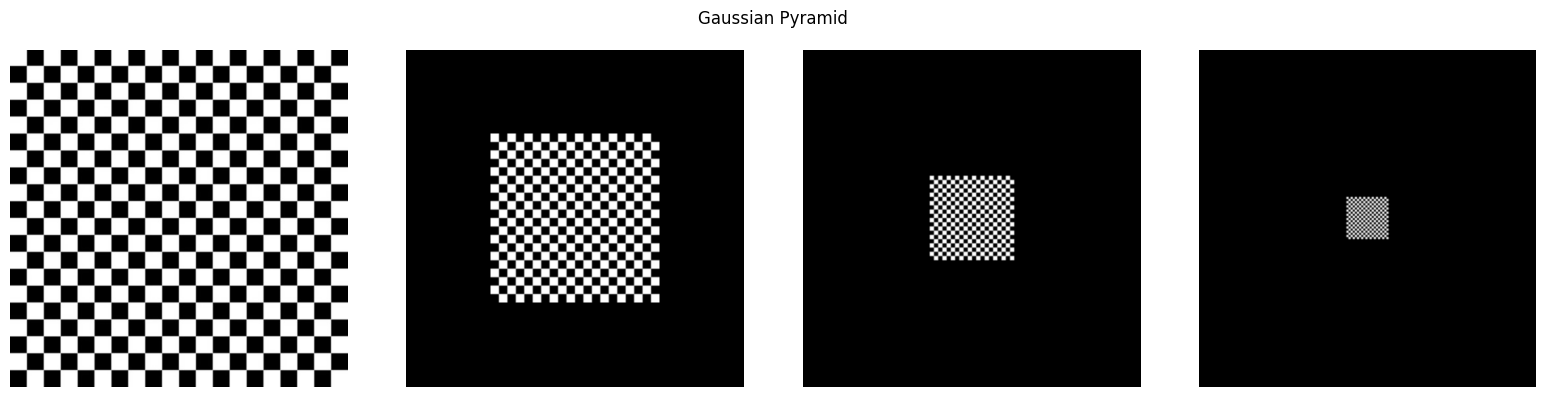

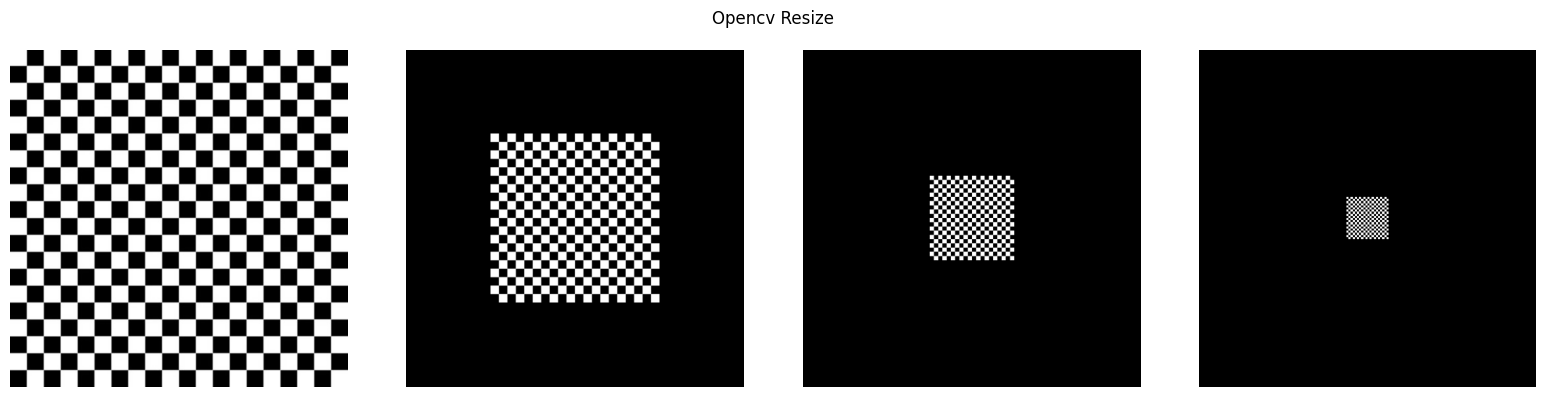

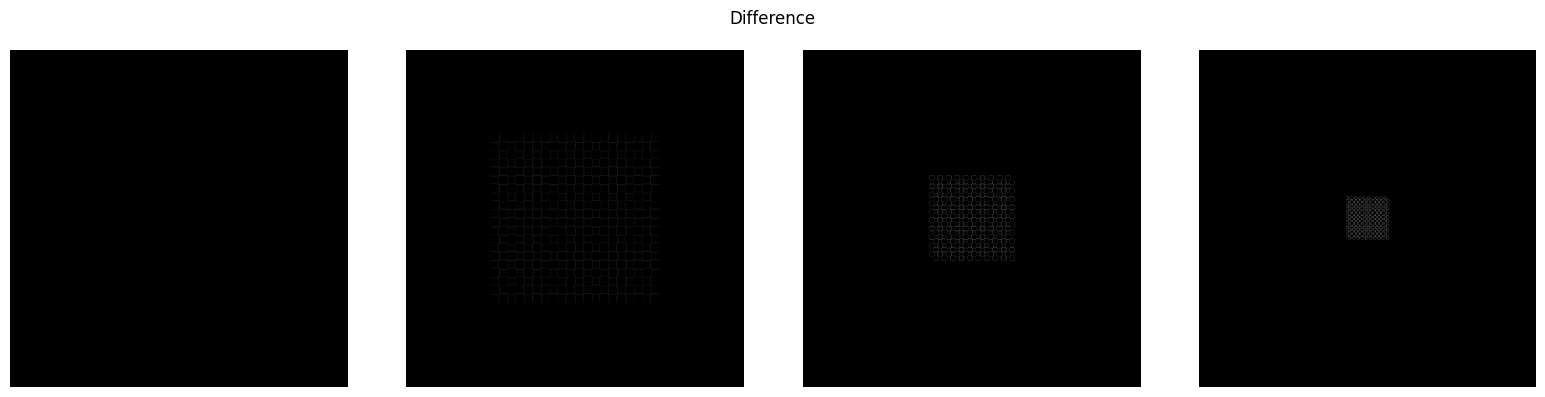

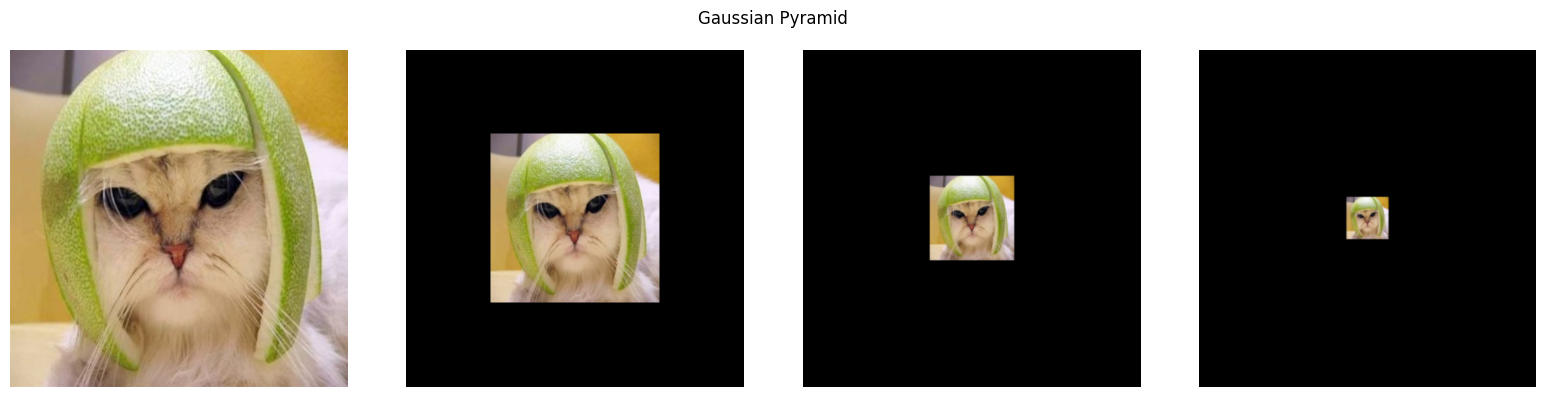

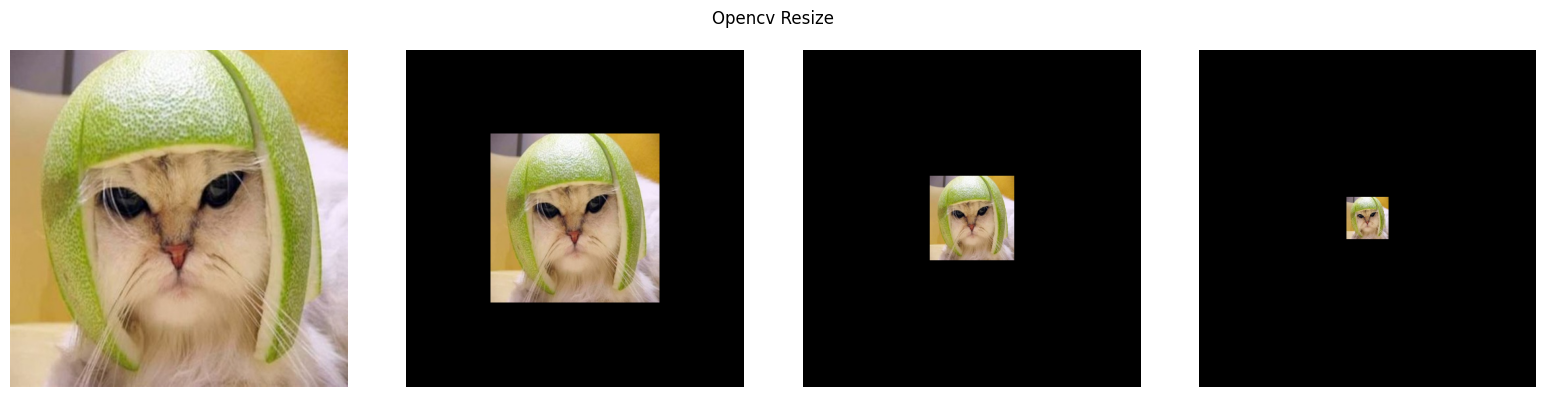

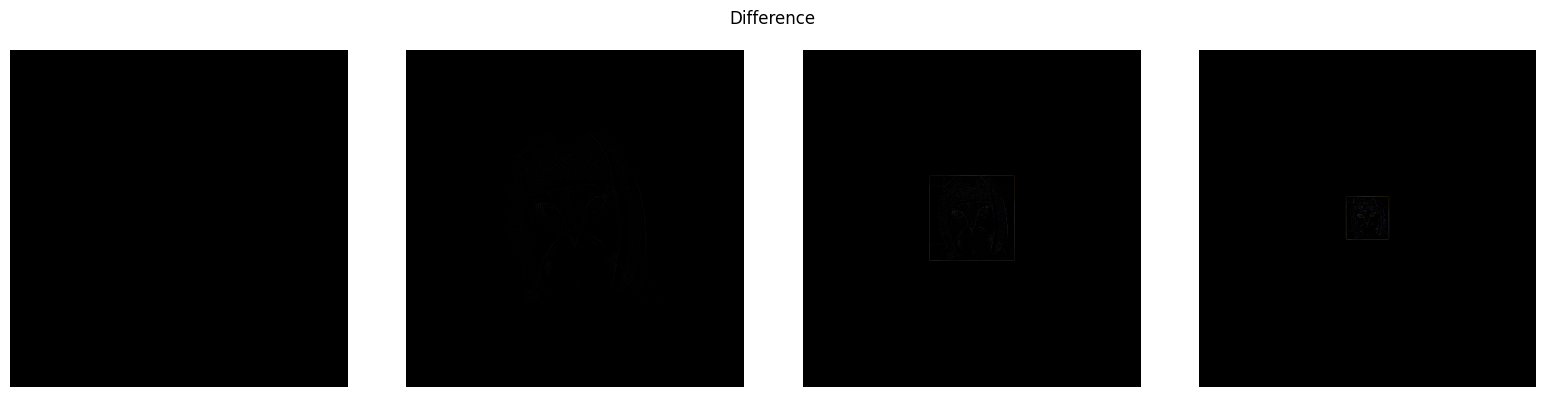

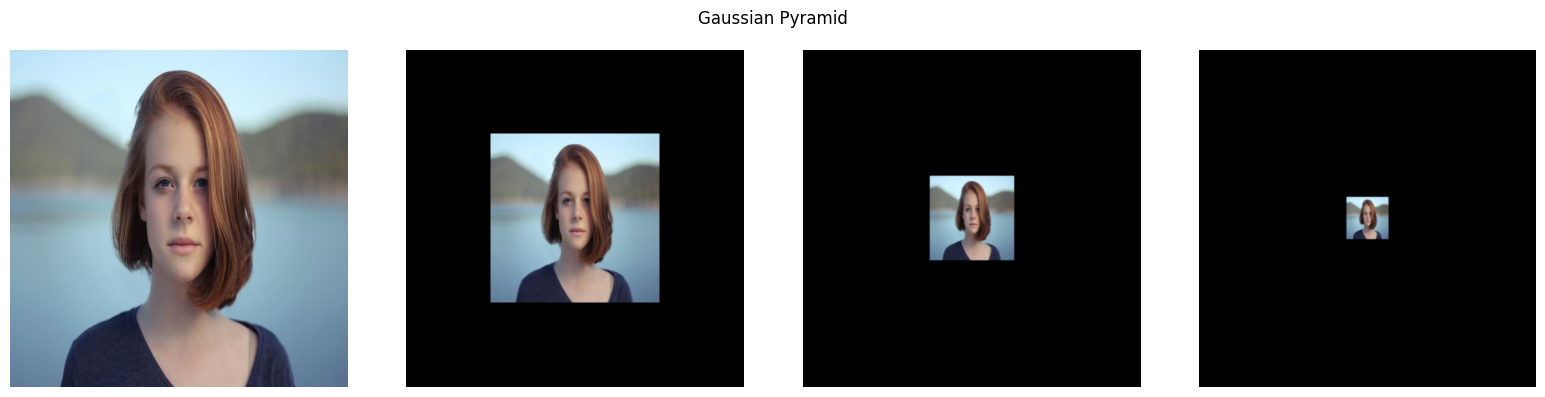

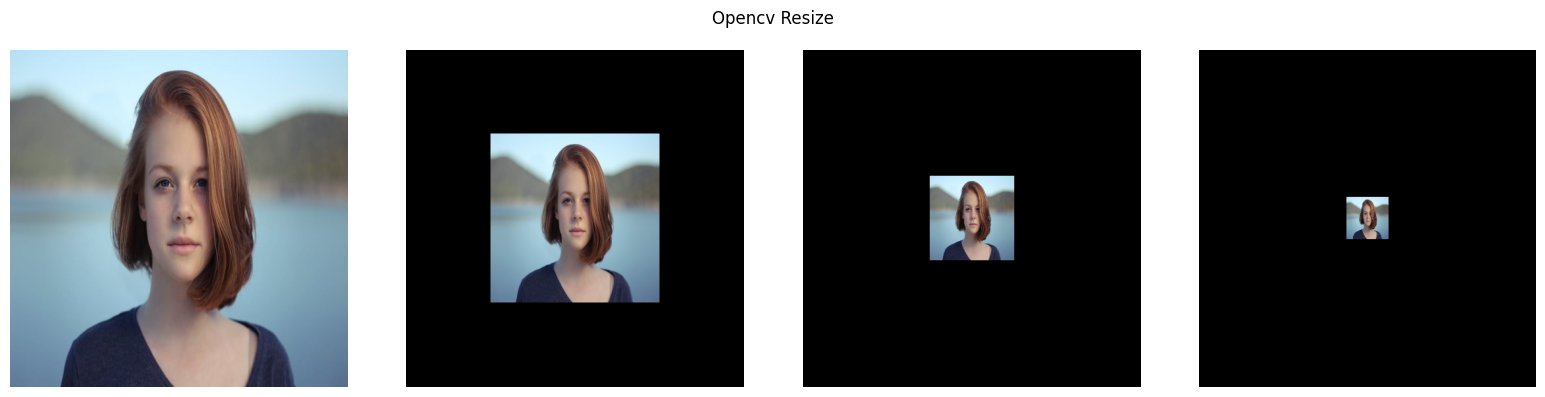

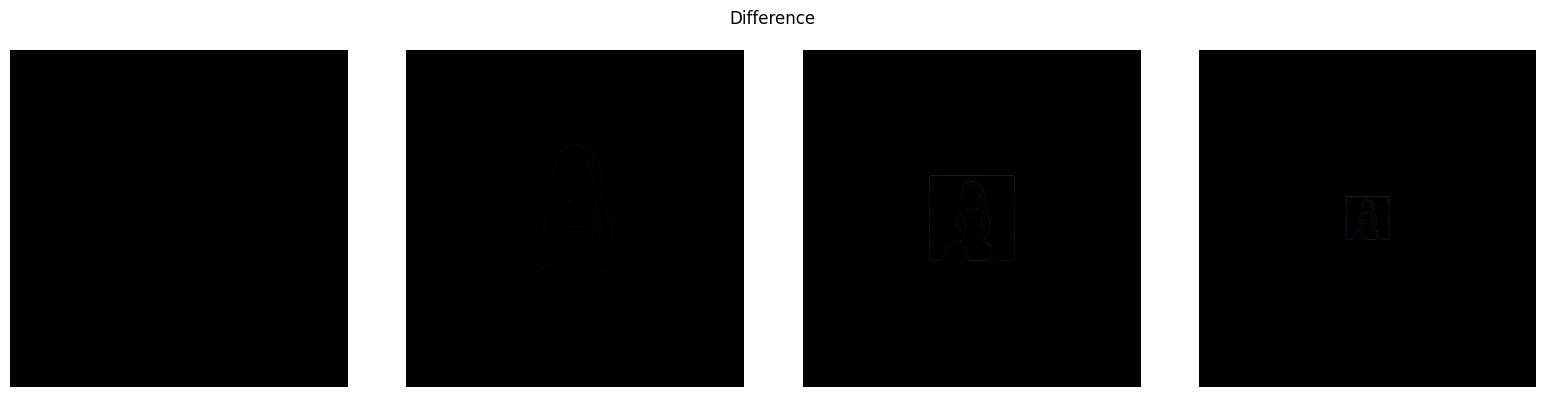

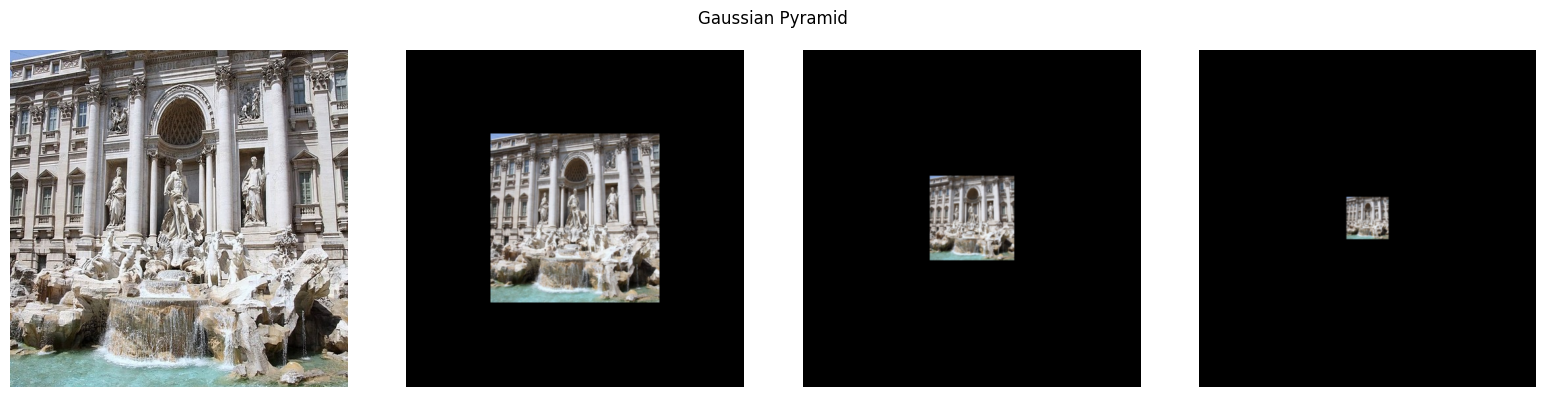

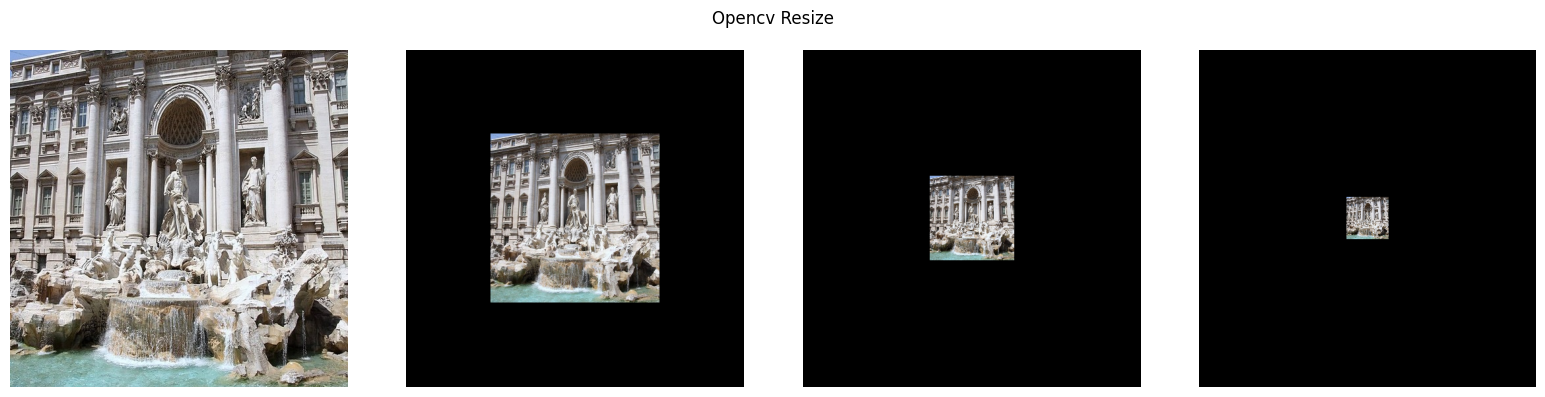

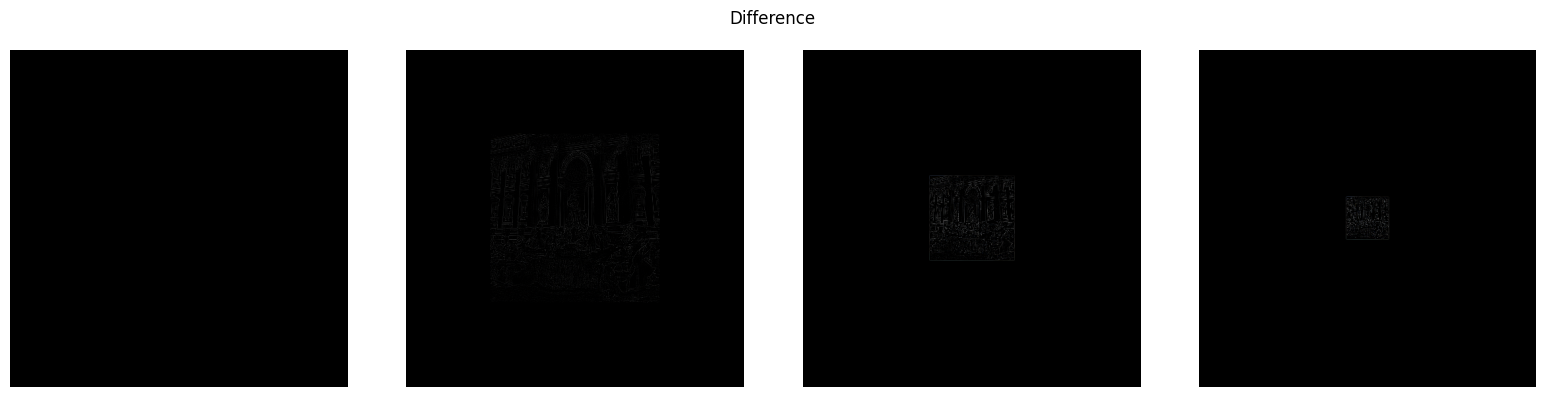

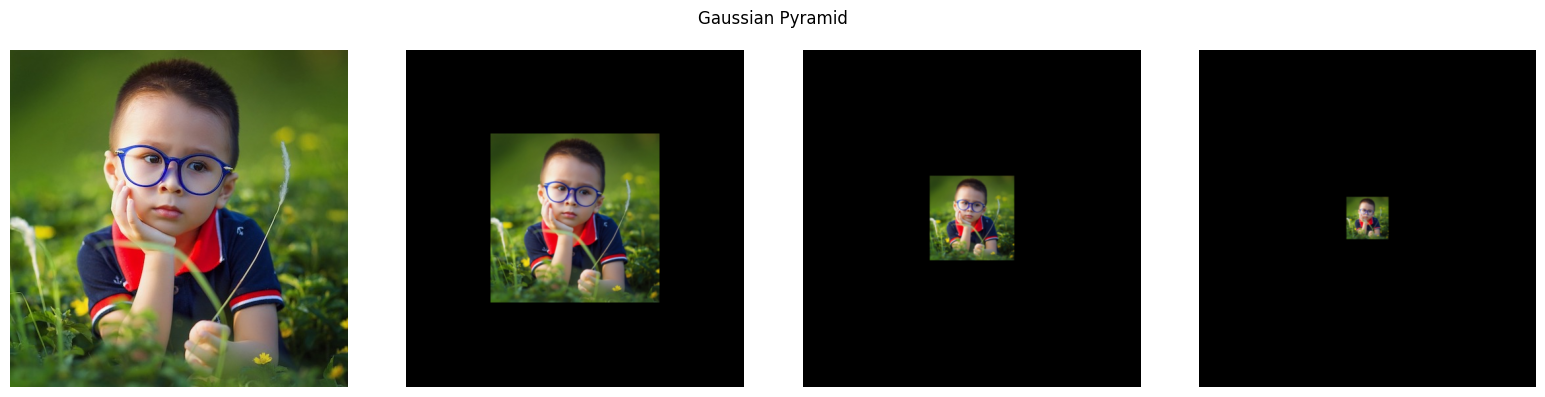

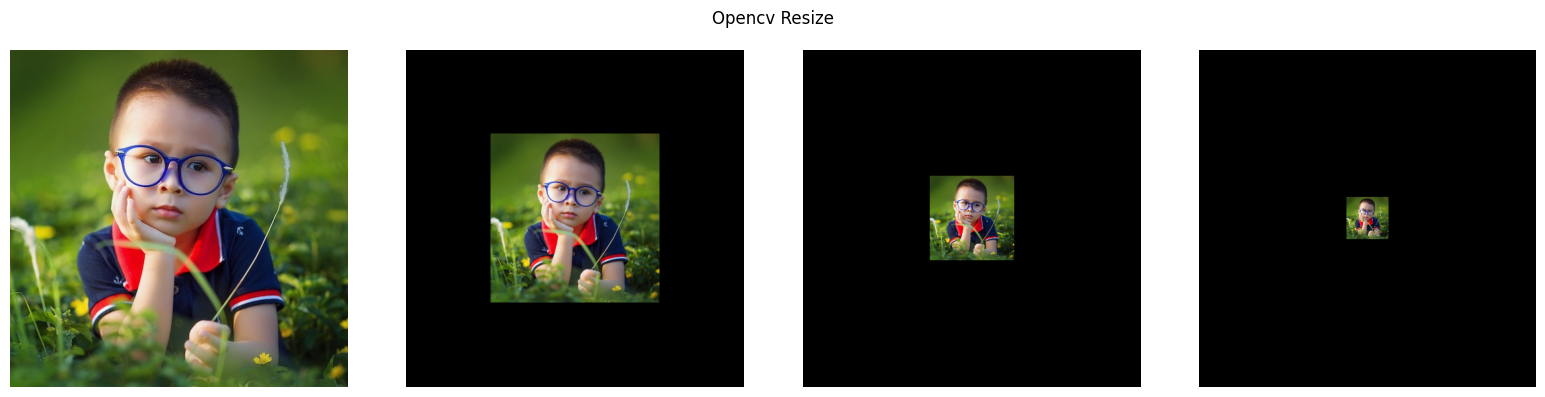

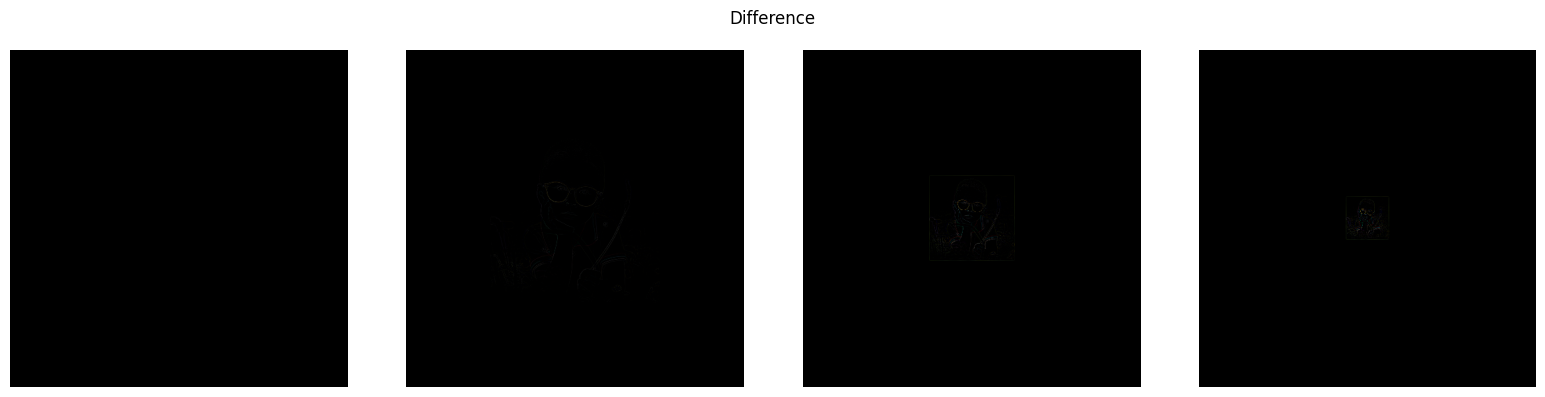

In [ ]:
for idx, image in enumerate(gt_images):

    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)

    diff = []
    for gauss_img, open_img in zip(s_image_pyramids, s_image_opecv_resize):
        diff.append(cv2.subtract(gauss_img, open_img))
    diff = np.array(diff)

    show_image_grid(s_image_pyramids, 1, 4, 'Gaussian Pyramid', figsize=16)
    show_image_grid(s_image_opecv_resize, 1, 4, 'Opencv Resize', figsize=16)
    show_image_grid(diff, 1, 4, 'Difference', figsize=16)

### Q2 [4 Marks]

You have to implement image blending technique using Laplacian Pyramids from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Image Blending Using Laplacian Pyramids](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f)

In [ ]:
def gaussian_pyramid_1(image, levels):
    """
    It constructs a Gaussian pyramid for the given image.
    """
    pyramid = [image]
    for i in range(1, levels):
        blurred = cv2.GaussianBlur(image, (5, 5), sigmaX=1)
        downsampled = cv2.resize(blurred, (blurred.shape[1]//2, blurred.shape[0]//2))
        pyramid.append(downsampled)
        image = downsampled

    return pyramid

def laplacian_pyramid(gaussian_pyramid_1):
    """
    It constructs a Laplacian pyramid from the Gaussian pyramid.
    """
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid_1)-1):
        next_level_upsampled = cv2.resize(gaussian_pyramid_1[i + 1], (gaussian_pyramid_1[i].shape[1], gaussian_pyramid_1[i].shape[0]))
        laplacian = cv2.subtract(gaussian_pyramid_1[i], next_level_upsampled)
        laplacian_pyramid.append(laplacian)

    # The last level of the Laplacian pyramid is the same as the last level of the Gaussian pyramid
    laplacian_pyramid.append(gaussian_pyramid_1[-1])
    return laplacian_pyramid

def blend_pyramids(laplacian_a, laplacian_b):
    """
    It blends two Laplacian pyramids.
    """
    blended_pyramid = []
    for lap_a, lap_b in zip(laplacian_a, laplacian_b):
        rows, cols, d = lap_a.shape
        # Blending left half of image_a and right half of image_b
        blended = np.hstack((lap_a[:, :cols//2], lap_b[:, cols//2:]))
        blended_pyramid.append(blended)

    return blended_pyramid

def reconstruct_from_laplacian(laplacian_pyramid):
    """
    It reconstructs the image from a Laplacian pyramid.
    """
    reconstructed_image = laplacian_pyramid[-1]  # Starting with the smallest level
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        reconstructed_image = cv2.resize(reconstructed_image, (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0]))
        reconstructed_image = cv2.add(reconstructed_image, laplacian_pyramid[i])

    return reconstructed_image

def laplacian_pyramid_blend_images(image_a, image_b, levels=4):
    """
    It blends two images using Laplacian pyramids.
    """
    # Generating Gaussian pyramids
    gaussian_a = gaussian_pyramid_1(image_a, levels)
    gaussian_b = gaussian_pyramid_1(image_b, levels)

    # Generating Laplacian pyramids
    laplacian_a = laplacian_pyramid(gaussian_a)
    laplacian_b = laplacian_pyramid(gaussian_b)

    # Blending Laplacian pyramids
    blended_pyramid = blend_pyramids(laplacian_a, laplacian_b)

    # Reconstructing blended image from blended Laplacian pyramid
    blended_image = reconstruct_from_laplacian(blended_pyramid)

    return blended_image


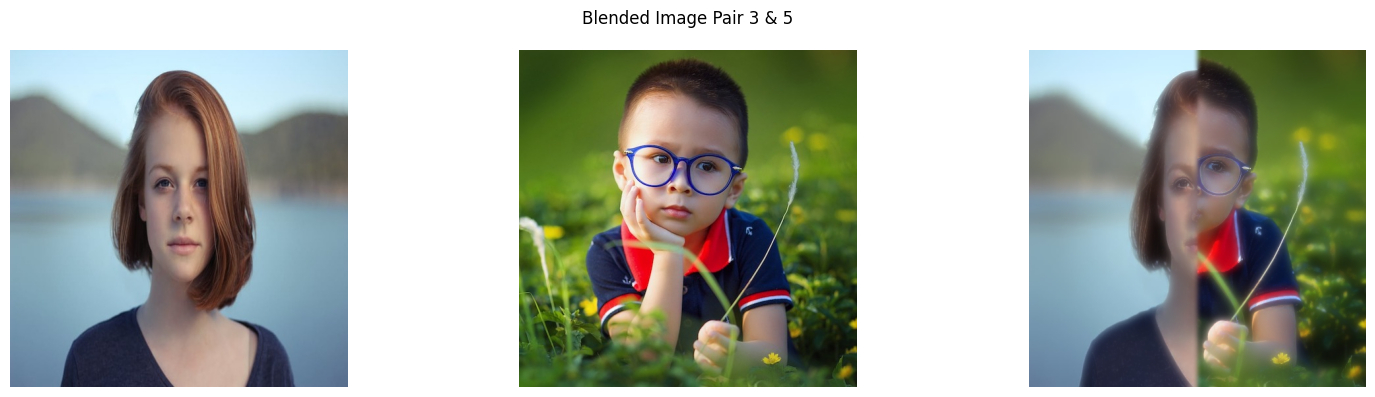

In [ ]:
blended_image = laplacian_pyramid_blend_images(gt_images[3], gt_images[5])
collage = np.array([gt_images[3], gt_images[5], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image Pair 3 & 5', figsize=16)

### Q3 [4 Marks]

Implement Harris and Hessian Corner Detector algorithm from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Harris and Hessian Corner Detector](https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd)

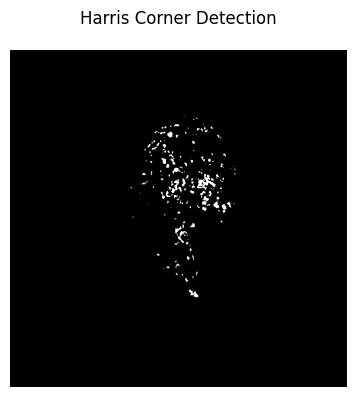

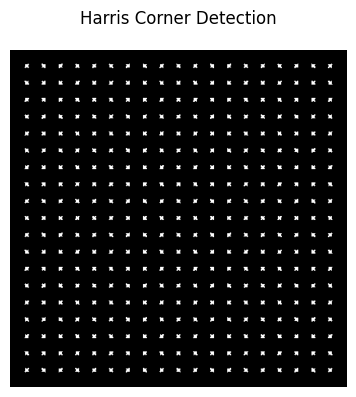

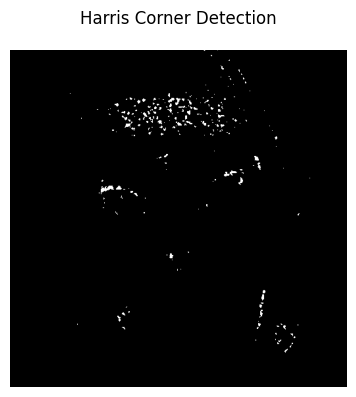

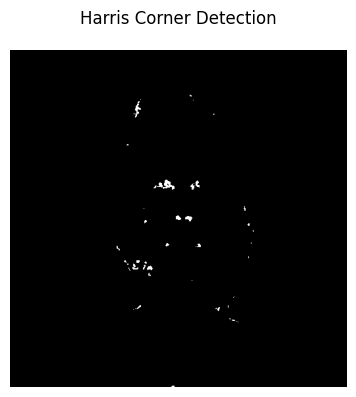

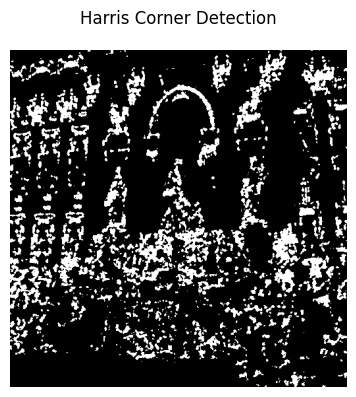

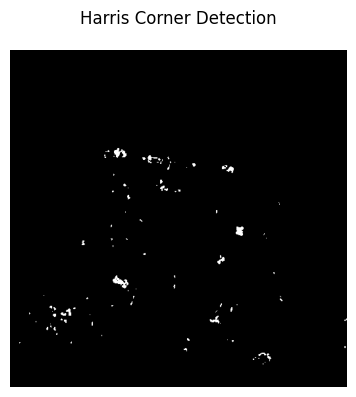

In [ ]:
def detect_harris_corner(image, alpha=0.04, threshold=1e-2):
    # Converting to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Computing gradients (Sobel filters)
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y

    # Computing products of gradients
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy

    # Applying Gaussian filter to the gradient products
    Sx2 = cv2.GaussianBlur(Ix2, (5, 5), sigmaX=1)
    Sy2 = cv2.GaussianBlur(Iy2, (5, 5), sigmaX=1)
    Sxy = cv2.GaussianBlur(Ixy, (5, 5), sigmaX=1)

    # Computing the Harris response matrix (R) for each pixel
    det_M = (Sx2 * Sy2) - (Sxy ** 2)  # Determinant of the structure tensor
    trace_M = Sx2 + Sy2  # Trace of the structure tensor

    R = det_M - alpha*(trace_M ** 2)  # Harris response

    # Thresholding the response
    R_max = np.max(R)
    corner_image = np.zeros_like(gray)

    # Marking corners above the threshold
    corner_image[R > threshold * R_max] = 255

    return corner_image

for image in gt_images:
    corner_image = detect_harris_corner(image)
    show_image_grid(corner_image, 1, 1, 'Harris Corner Detection', figsize=16)


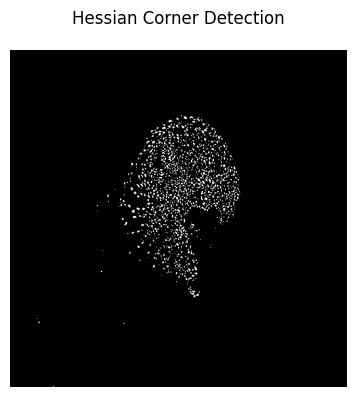

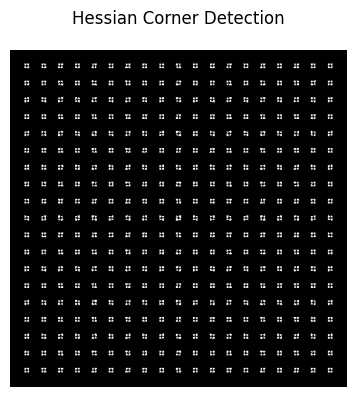

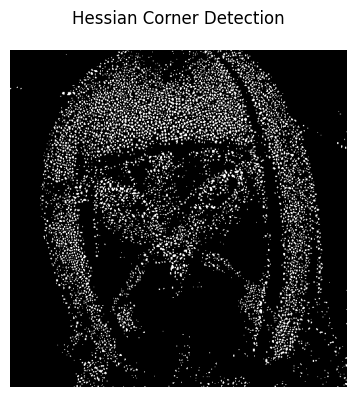

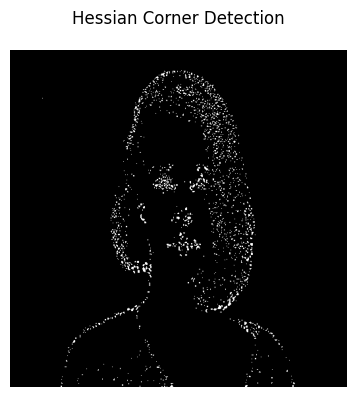

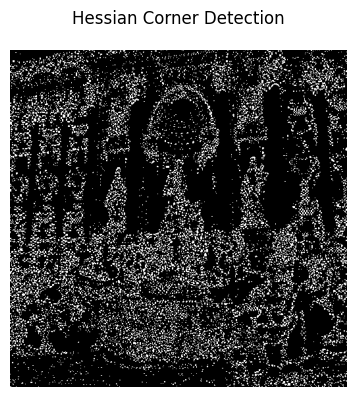

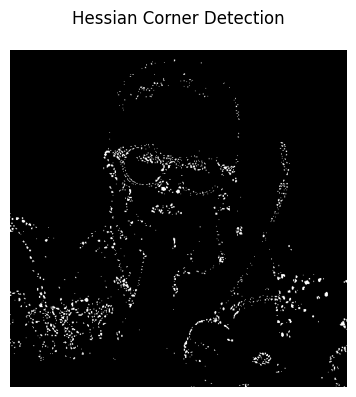

In [ ]:
def detect_hessian_corner(image, alpha=0.04, threshold=1e-2):
    # Converting to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Computing second-order derivatives
    Ixx = cv2.Sobel(gray, cv2.CV_64F, 2, 0, ksize=3)  # Second-order derivative in X
    Iyy = cv2.Sobel(gray, cv2.CV_64F, 0, 2, ksize=3)  # Second-order derivative in Y
    Ixy = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=3)  # Mixed derivative

    # Applying Gaussian filter to the second-order derivatives
    Sxx = cv2.GaussianBlur(Ixx, (5, 5), sigmaX=1)
    Syy = cv2.GaussianBlur(Iyy, (5, 5), sigmaX=1)
    Sxy = cv2.GaussianBlur(Ixy, (5, 5), sigmaX=1)

    # Computing the determinant and trace of the Hessian matrix
    det_H = (Sxx * Syy) - (Sxy ** 2)  # Determinant of Hessian matrix
    trace_H = Sxx + Syy  # Trace of Hessian matrix

    # Thresholding the determinant to detect corners
    R = det_H - alpha * (trace_H ** 2)  # Response function

    R_max = np.max(R)
    corner_image = np.zeros_like(gray)

    # Marking corners above the threshold
    corner_image[R > threshold * R_max] = 255

    return corner_image

for image in gt_images:
    corner_image = detect_hessian_corner(image)
    show_image_grid(corner_image, 1, 1, 'Hessian Corner Detection', figsize=16)